In [1]:
import matplotlib
matplotlib.use('nbagg')
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
%load_ext pyclanglite.rich_display

/usr/local/lib/python2.7/dist-packages/ipython-4.0.0-py2.7.egg/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from vplants.autowig import autowig
asg = autowig.AbstractSemanticGraph()

In [4]:
from pyclanglite.ast import AbstractSyntaxTree

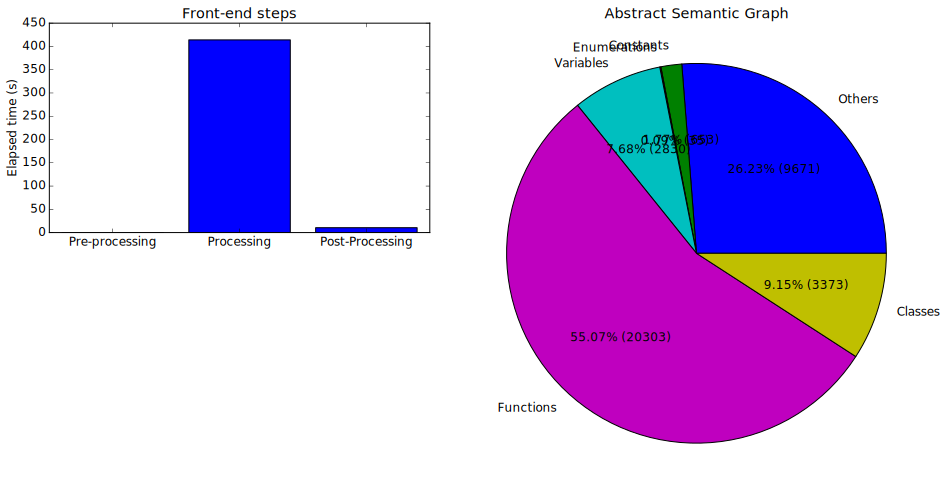

In [5]:
from path import path
rootdir = path('../../statiskit/').abspath()
includedir = rootdir + "/core/build-scons/include"

headers = [str(f) for f in includedir.walkfiles('*.h')]

flags = ['-x', 'c++', '-g', '-std=c++11', '-stdlib=libstdc++',
         '-I/usr/include', '-I' + str(includedir), '-D__STDC_CONSTANT_MACROS',
         '-I/usr/local/lib/clang/3.7.0/include', '-D__STDC_LIMIT_MACROS']

autowig.front_end.plugin = 'pyclanglite'
autowig.front_end(asg, headers, flags=flags, silent=True,
          force_overload=True, bootstrap=3)#,
#                  append='size_t s = sizeof(struct ::statiskit::UnivariateEmpiricalDistributionEstimation<statiskit::QuantitativeUnivariateEmpiricalDistribution<statiskit::DiscreteUnivariateDistribution>, statiskit::DiscreteUnivariateDistributionEstimation>::Estimator);')

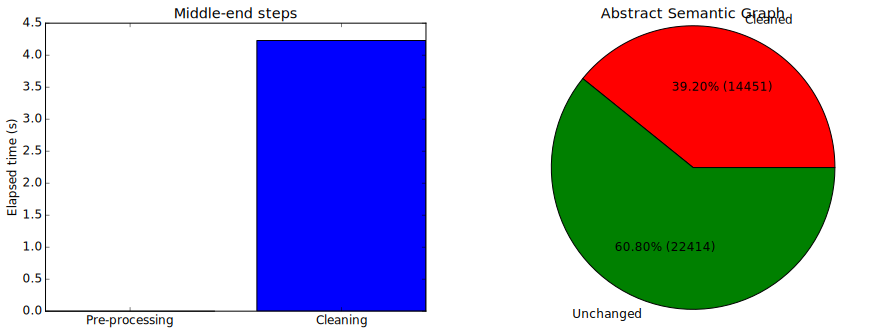

In [6]:
diag = autowig.middle_end(asg)

primaries = [header for header in asg.files(header=True) if header.is_primary]
for hdr in asg.files(header=True):
    if not hdr.is_primary and hdr.include in primaries:
        hdr.is_primary = True
        
for inc in asg.directories():
    if inc.as_include:
        if inc.globalname + 'c++/' in asg:
            for vsn in asg[inc.globalname + 'c++/'].directories:
                vsn.as_include = True
                for hdr in vsn.files:
                    if hdr.suffix == '':
                        hdr.is_primary = True
        elif inc.globalname + 'boost/' in asg:
            for hdr in sg[inc.globalname + 'boost/'].files:
                hdr.is_primary = True
                
for tpl in asg.classes('.*(unique|weak|shared)_ptr$', templated=True,
                       specialized=False):
    tpl.is_smart_pointer = True
    
diag

In [7]:
for cls in ['vector', 'set', 'array']:
    for spc in asg['class ::std::' + cls].specializations(partial=False):
        for mtd in spc.methods():
            if mtd.localname == 'operator[]':
                mtd.boost_python_export = False
for cls in asg.classes('struct ::std::less'):
    cls.boost_python_export = False
for cls in asg.classes('class ::__gnu_cxx::new_allocator.*'):
    cls.boost_python_export = False
#for cls in asg.classes('struct ::std::add_[rl]value_reference.*'):
#    cls.boost_python_export = False
for cls in asg.classes('class ::std::allocator.*'):
    cls.boost_python_export = False
#for cls in asg.classes('struct ::std::_*is_.*'):
#    cls.boost_python_export = False
for cls in asg.classes('class ::std::initializer_list.*'):
    cls.boost_python_export = False
for cls in asg.classes('class ::std::reverse_iterator.*'):
    cls.boost_python_export = False
for cls in asg.classes('struct ::std::_Rb_tree_node.*'):
    cls.boost_python_export = False
asg['::statiskit'].boost_python_export = False

autowig.back_end.plugin = 'boost_python:in_memory'
autowig.back_end(asg,
         filename = rootdir + '/core/src/wrapper/statiskit_core.cpp',
         target = rootdir + '/core/src/statiskit/core',
         pattern = '^(.*)statiskit(.*)',
         held_type = 'class ::std::shared_ptr',
         closure = True)

Total files generated in memory,145 (f)
Total source lines of code,3119 (l)
Development effort estimate,10.73 (p.m)
Schedule estimate,5.74 (m)
Estimated average number of developers,1.87 (p)


In [8]:
node = asg[rootdir + '/core/src/wrapper/statiskit_core.cpp']
node.append = dict(LIBS=['statiskit_core'])
#node.add_boost_python_export(rootdir +
#                             '/core/src/wrapper/function_statiskit_multivariate_data_frame_iterator_bool.cpp')
#asg.functions('::std::pair<const double, std::pair<double, std::shared_ptr<statiskit::UnivariateHistogramDistribution> > >::swap').pop().boost_python_export = False

In [9]:
pattern = 'struct ::arma::Base<double, arma::Op<'
pattern += 'arma::(Row|Col|diagview|subview_(col|row))<double>'
pattern += ', arma::op_strans> >'
for cls in asg.nodes(pattern):
    cls.boost_python_export = False
for mtd in asg.functions('::arma::SpSubview<double>::check_overlap.*'):
    mtd.boost_python_export = False
for mtd in asg.functions('::arma::SpMat<double>::operator\*=.*'):
    target = mtd.parameters[0].type.target.globalname
    if target  == 'class ::arma::subview<double>':
        mtd.boost_python_export = False
        
autowig.back_end(asg,
         filename = rootdir + '/misc/src/wrapper/statiskit_misc.cpp',
         target = rootdir + '/misc/src/statiskit/misc',
         pattern = '(.*)',
         held_type = 'class ::std::shared_ptr')

Total files generated in memory,154 (f)
Total source lines of code,5447 (l)
Development effort estimate,20.03 (p.m)
Schedule estimate,7.14 (m)
Estimated average number of developers,2.81 (p)


In [10]:
autowig.back_end.plugin = 'boost_python:on_disk'
autowig.back_end(asg)

Total files generated on disk,299 (f)
Total source lines of code,9442 (l)
Development effort estimate,37.08 (p.m)
Schedule estimate,8.85 (m)
Estimated average number of developers,4.19 (p)


In [ ]:
asg.add_sconstruct(rootdir + '/misc')
asg.scons('-j', '2')

In [ ]:
asg.add_sconstruct(rootdir + '/core')
asg.scons('-j', '2')